In [136]:
## IMPORTS

# BASE
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import re

# SKLEARN
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


In [137]:
## CHARTS

def plot_sales(dataframe, title, ylabel, xlabel, color='red'):
    
    plt.figure(figsize=(15, 3))
    plt.title(title)
    plt.ylabel(ylabel, color='white')
    # format y axis as currency
    # plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

    plt.xlabel(xlabel, color='white')

    plt.bar(dataframe.index, dataframe['Total Sales'])
    # plot mean price in 2nd y axis
    plt.twinx()
    plt.ylabel('Mean Price', color='white')
    # plt.gca().yaxis.set_major_formatter('R${:,.0f}'.format)

    plt.plot(dataframe.index, dataframe['Mean Price'], color=color, linewidth=4)
    plt.show()

In [138]:
## OPEN FILES

## PREPROCESSING
lots = pd.read_csv('../clean-files/artsy_auctions_artworks_info.csv')

print('Lots count:', lots.shape[0])
lots.columns

Lots count: 11381


Index(['url', 'img_url', 'Price', 'Artist', 'Artist_url', 'Title',
       'Pre-sale estimate', 'Medium', 'Sale Date', 'Auction house',
       'Price_USD', 'Height (cm)', 'Width (cm)', 'Area (cm²)', 'Price_fix',
       'Price_unit', 'Sale details', 'Price (USD)', 'Price (USD / cm²)',
       'Price (USD / cm)', 'Technique', 'Sold', 'Year', 'Year of sale'],
      dtype='object')

In [139]:
# SOLD LOTS
sold_lots = lots[lots['Sold'] == True]
print('Sold lots: ', len(sold_lots))

Sold lots:  11381


In [140]:
# lots['Sale Date']
# treat Sale Date as date
sold_lots['Sale Date'] = pd.to_datetime(sold_lots['Sale Date'])

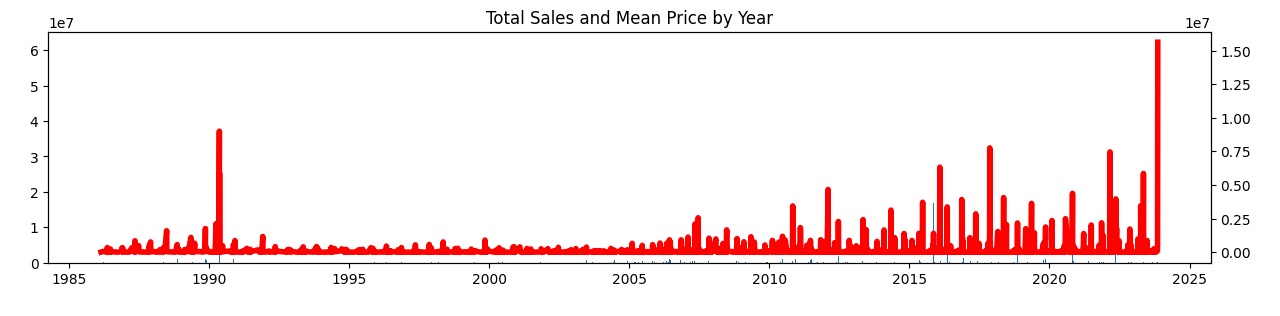

In [141]:
# PLOT TOTAL SALES AND MEAN PRICE BY YEAR
sales = pd.DataFrame(sold_lots.groupby('Sale Date')['Price (USD)'].sum())
sales['Total Sales'] = sold_lots.groupby('Sale Date')['Price (USD)'].sum()
sales['Mean Price'] = sold_lots.groupby('Sale Date')['Price (USD)'].mean()

plot_sales(sales, 'Total Sales and Mean Price by Year', 'Total Sales', 'Year')

In [142]:
# TOP ARTISTS BY SALES COUNT

# dataframe with 2 columns: #sales, total sales ($) and mean price ($)
top_artists = pd.DataFrame(sold_lots['Artist'].value_counts())
top_artists['Total Sales'] = sold_lots.groupby('Artist')['Price (USD)'].sum()
top_artists['Mean Price'] = sold_lots.groupby('Artist')['Price (USD)'].mean()
# include mean area
top_artists['Mean Area'] = sold_lots.groupby('Artist')['Area (cm²)'].mean()
# mean price per area
top_artists['Mean Price per Area'] = top_artists['Mean Price'] / top_artists['Mean Area']

top_artists = top_artists.sort_values(by='Total Sales', ascending=False)
top_artists.drop('Mean Area', axis=1, inplace=True)
top_artists.head()

,count,Total Sales,Mean Price,Mean Price per Area
Artist,,,,
Marc Chagall,8244,1.235846e+09,149908.505095,48.411105
Victor Vasarely,2872,8.340607e+07,29041.109680,4.810186
Cândido Portinari,120,1.536938e+07,128078.191667,43.738665
Emiliano Di Cavalcanti,129,1.007514e+07,78101.837209,21.789270
Vicente do Rego Monteiro,16,6.843660e+05,42772.875000,15.533820


In [143]:
## ARTISTS DATAFRAMES

artists = sold_lots.groupby('Artist').apply(lambda x: x.sort_values('Price (USD)', ascending=False)).reset_index(drop=True).groupby('Artist')

artists_dataframes = {}
for artist in artists:
    artist_name = artist[0]
    artist_df = artist[1]
    artists_dataframes[artist_name] = artist_df

Found 2872 lots for Victor Vasarely


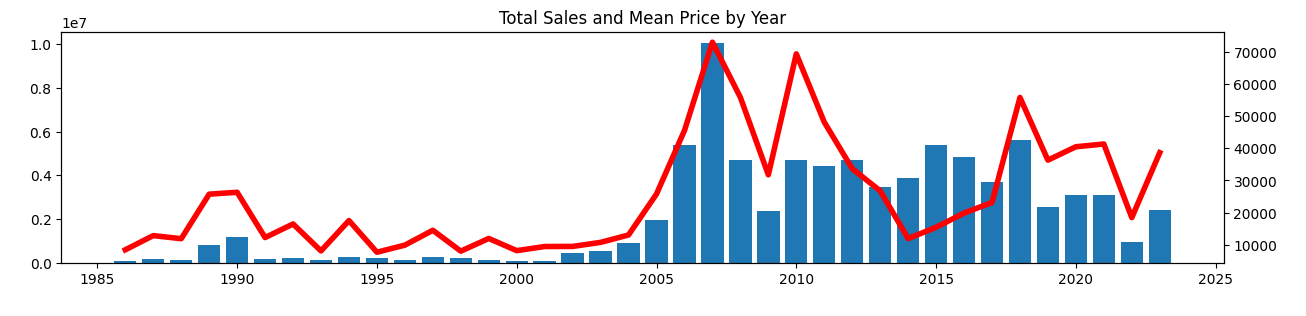

In [144]:
artist_name = 'Victor Vasarely'
artist_df = artists_dataframes[artist_name]

# PLOT TOTAL SALES AND MEAN PRICE BY YEAR
artist_sales = pd.DataFrame(artist_df.groupby('Year of sale')['Price (USD)'].sum())
artist_sales['Total Sales'] = artist_df.groupby('Year of sale')['Price (USD)'].sum()
artist_sales['Mean Price'] = artist_df.groupby('Year of sale')['Price (USD)'].mean()

print(f'Found {artist_df.shape[0]} lots for {artist_name}')
plot_sales(artist_sales, 'Total Sales and Mean Price by Year', 'Total Sales', 'Year')

In [145]:
lots['Technique'].value_counts()

Technique
print                                         6080
painting                                      3032
works on paper                                 906
drawing                                        263
----                                           256
                                              ... 
collage of colored boards on board               1
wooden relief multiple painted in colours.       1
basf polystyrene color blocks multiple           1
hologram collage on vinyl on board               1
vasarely 1964 on the reverse                     1
Name: count, Length: 376, dtype: int64

In [146]:
## FIT PRICE MODELS

# hide all warnings
import warnings
warnings.filterwarnings('ignore')

lots_to_model = lots[['Artist', 'Width (cm)', 'Height (cm)', 'Year', 'Year of sale', 'Price (USD)', 'Technique']].dropna()

print(lots_to_model.shape)

X = lots_to_model.drop(['Price (USD)'], axis=1)
y = lots_to_model['Price (USD)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = pd.get_dummies(X_train, columns=['Artist', 'Technique'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Artist', 'Technique'], drop_first=True)

# add to X_test all columns that are in X_train but not in X_test
for column in X_train.columns:
    if column not in X_test.columns:
        X_test[column] = 0

# remove from x_test all columns that are in X_test but not in X_train
for column in X_test.columns:
    if column not in X_train.columns:
        X_test.drop(column, axis=1, inplace=True)

# sort columns alphabetically
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

# function that fits all models and put metrics into a dataframe
# the function returns the dataframe and a dictionary with the models
def fit_models(X_train, y_train, X_test, y_test):
    models = {'Linear Regression': LinearRegression(),
              'Decision Tree': DecisionTreeRegressor(),
              'Random Forest': RandomForestRegressor(),
              'Gradient Boosting': GradientBoostingRegressor()}

    models_df = pd.DataFrame(columns=['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
                             index=['R2', 'RMSE', 'MAE'])

    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        r2 = r2_score(y_test, pred)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)
        
        models_df[name] = [r2, rmse, mae]

    return models_df, models

models_df, models = fit_models(X_train, y_train, X_test, y_test)

models_df

(8040, 7)


,Linear Regression,Decision Tree,Random Forest,Gradient Boosting
R2,0.062408,0.013083,0.437007,0.447053
RMSE,396974.581859,407282.797223,307614.779973,304858.072564
MAE,162453.927279,73908.663120,63453.084624,88002.481459


In [147]:
## SAVE LOCALLY MODEL AND X_TEST

# save model to models folder
model = models['Gradient Boosting']
with open('./models/artsy_auctions_gb_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# save X_test as csv
X_test.to_csv('./models/artsy_auctions_X_test.csv', index=False)